In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from data_generation import *
from torchvision import transforms
from PIL import Image, ImageDraw
from joblib import Parallel, delayed

In [2]:
def get_distances(positions):
    """
    euclidean distances between consecutive points
    """
    distances = []
    for i in range(len(positions) - 1):
        tuple_subtraction = (
            positions[i + 1][0] - positions[i][0],
            positions[i + 1][1] - positions[i][1],
        )
        distances.append(np.linalg.norm(tuple_subtraction))
    return distances

In [3]:
sequence_length = 10
speed_min = 10
speed_max = 15
direction_min = 0
direction_max = 2 * np.pi
position_x_min = 2
position_x_max = 14
position_y_min = 6
position_y_max = 14
gravity_min = 0
gravity_max = 4
restitution_min = 0.7
restitution_max = 1

In [4]:
distances = []
for _ in range(100):
    sequence, positions = generate_random_sequence(
        sequence_length=sequence_length,
        speed_min=speed_min,
        speed_max=speed_max,
        direction_min=direction_min,
        direction_max=direction_max,
        position_x_min=position_x_min,
        position_x_max=position_x_max,
        position_y_min=position_y_min,
        position_y_max=position_y_max,
        gravity_min=gravity_min,
        gravity_max=gravity_max,
        restitution_min=restitution_min,
        restitution_max=restitution_max,
    )
    distances += get_distances(positions)

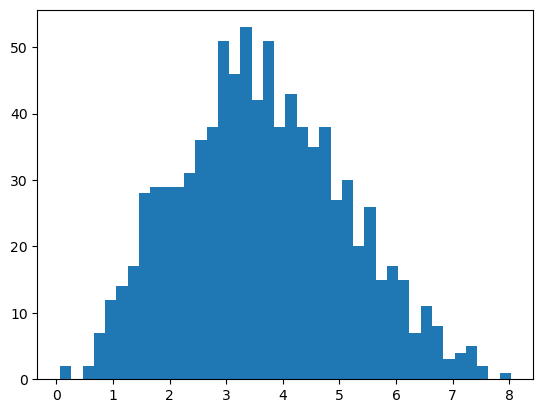

In [5]:
# plot histogram of distances
plt.hist(distances, bins=40)
plt.show()

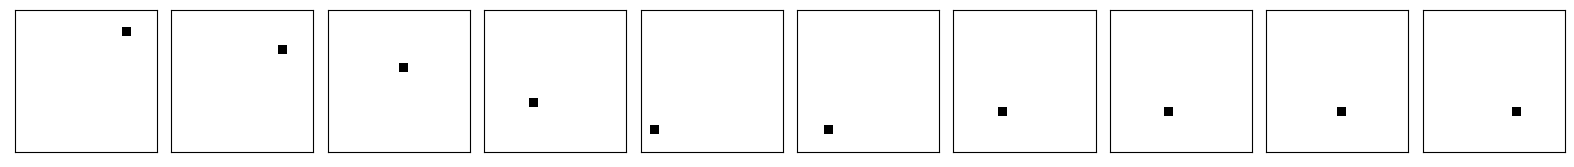

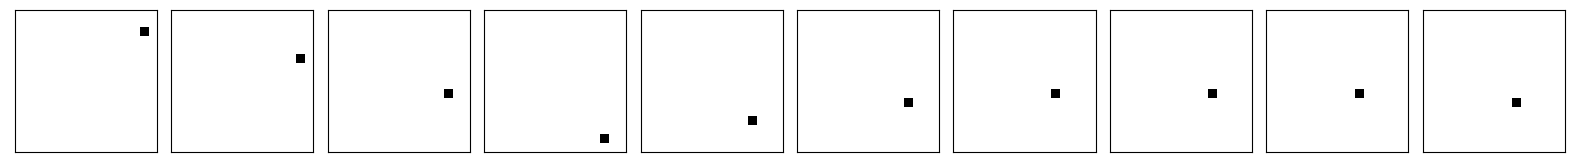

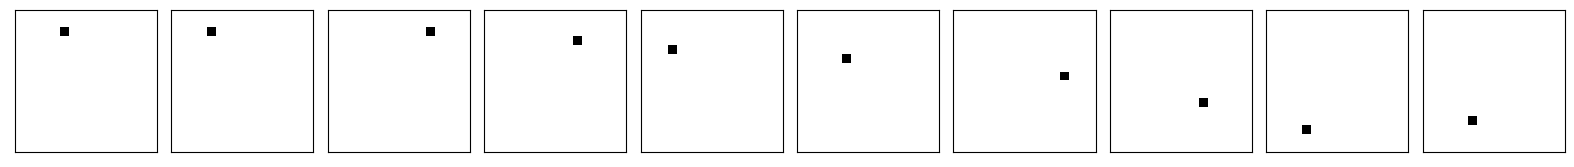

In [6]:
for _ in range(3):
    sequence, positions = generate_random_sequence(
        sequence_length=sequence_length,
        speed_min=speed_min,
        speed_max=speed_max,
        direction_min=direction_min,
        direction_max=direction_max,
        position_x_min=position_x_min,
        position_x_max=position_x_max,
        position_y_min=position_y_min,
        position_y_max=position_y_max,
        gravity_min=gravity_min,
        gravity_max=gravity_max,
        restitution_min=restitution_min,
        restitution_max=restitution_max,
    )
    display_sequence(sequence)

In [11]:
def generate_single_sequence(args):
    return generate_random_sequence(**args)


class PixelDataset(Dataset):
    def __init__(self, num_sequences, sequence_length, **kwargs):
        self.data = []
        self.targets = []

        # Create a list of dictionaries, each containing the arguments for one sequence generation
        args_list = [
            {"sequence_length": sequence_length, **kwargs} for _ in range(num_sequences)
        ]

        # Parallel generation of sequences using joblib
        results = Parallel(n_jobs=-1)(
            delayed(generate_single_sequence)(args) for args in args_list
        )

        # Unpack results and populate data and targets
        for images, positions in results:
            self.data.append(images)
            self.targets.append(positions)

        self.transform = transforms.ToTensor()
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence_of_images = [self.transform(image) for image in self.data[idx]]
        sequence_of_images = torch.stack(sequence_of_images)
        target_positions = torch.FloatTensor(self.targets[idx])
        return sequence_of_images, target_positions


# Hyperparameters and other parameters for generate_random_sequence
N = 50000  # Number of sequences
L = 10  # Length of each sequence

# Creating Dataset and DataLoader
dataset = PixelDataset(
    N,
    L,
    speed_min=speed_min,
    speed_max=speed_max,
    direction_min=direction_min,
    direction_max=direction_max,
    position_x_min=position_x_min,
    position_x_max=position_x_max,
    position_y_min=position_y_min,
    position_y_max=position_y_max,
    gravity_min=gravity_min,
    gravity_max=gravity_max,
    restitution_min=restitution_min,
    restitution_max=restitution_max,
)
torch.save(dataset, "dataset.pt")